In [2]:
%pylab inline
import numpy as np

class NeuralNetwork(object):
    
    def __init__(self, L, Lambda = 0):
        # L is the array describing the hyperparameters
        # L = [inputs, hidden1, hidden2, ..., outputs]
        self.L = L
        
        # Initialize each hidden layer
        self.W = []
        
        # For each hidden layer hyperparameter, assign random weights
        for w in range(0, len(L) - 1):
            self.W.append(np.random.randn(self.L[w], self.L[w+1]))
        
        # The regularization coefficient
        self.Lambda = Lambda
    
    def sigmoid(self, z):
        # Sigmoid activation function
        #vSigmoidFast = np.vectorize(self.sigmoidFast)
        #return vSigmoidFast(z)
        return 1 / (1 + np.exp(-z))
        #return z / (1 + abs(z))
        
    def sigmoidPrime(self, z):
        # Derivative of the sigmoid function
        #return np.exp(-z) / ((1 + np.exp(-z)) ** 2)
        y = self.sigmoid(z)
        return y * (1 - y)
        
    def forward(self, X):
        # Forward propagation of the input signals through the network
        # Initialize the weighted inputs and the activations and receive inputs
        self.Z = [X]
        self.A = [self.Z[0]]
        
        # Propagate
        for n in range(1, len(self.L)):
            self.Z.append(self.A[n-1].dot(self.W[n-1]))
            self.A.append(self.sigmoid(self.Z[n]))
            
        # Return the predicted values
        yHat = self.A[len(self.L) - 1]
        return yHat
    
    def costFunction(self, X, Y):
        # Compute the cost function using the current weights
        # Quadratic cost function: sum of the squared errors
        self.yHat = self.forward(X)
        J = 0.5 * sum((Y - self.yHat) ** 2)
        regJ = 0
        for w in range(0, len(self.L) - 2):
            regJ = regJ + 0.5 * self.Lambda * sum(self.W[w] ** 2)
        J = J + regJ
        return J
    
    def costFunctionPrime(self, X, Y):
        # Compute the gradient of the cost function over weights
        yHat = self.forward(X)
        
        # Compute the first error
        N = len(self.L) - 1 #max layer index
        i = N #index pointing to a layer
        delta = [np.multiply(yHat - Y, self.sigmoidPrime(self.Z[i]))]
        dJdW = [np.dot(self.A[i-1].T, delta[N-i]) + self.Lambda * self.W[i-1]]
        i = i - 1
        
        # Compute the rest of the errors, where the last error is the first in the list
        while i > 0:
            delta_i = np.dot(delta[N-i-1], self.W[i].T) * self.sigmoidPrime(self.Z[i])
            delta.append(delta_i)
            dJdW_i = np.dot(self.A[i-1].T, delta_i) + self.Lambda * self.W[i-1]
            dJdW.append(dJdW_i)
            i = i - 1
        
        # Return the list of gradients
        return dJdW
    
    # Helper functions
    # All assume that there is at least one hidden layer
    def getParams(self):
        # The set of all parameters or the weights
        i = 0
        params = np.concatenate((self.W[i].ravel(), self.W[i+1].ravel()))
        i = 2
        while i < len(self.L)-1:
            params = np.concatenate((params, self.W[i].ravel()))
            i = i + 1
        return params
    
    def setParams(self, params):
        # Set the parameters from the collection of weights
        i = 0
        start = 0
        end = 0
        while i < len(self.L)-1:
            start = end
            end = end + self.L[i] * self.L[i+1]
            self.W[i] = np.reshape(params[start:end], (self.L[i], self.L[i+1]))
            i = i + 1
            
    def computeGradients(self, X, Y):
        # Compute and return the set of all gradients
        dJdW = self.costFunctionPrime(X, Y)
        i = len(self.L) - 2
        grad = np.concatenate((dJdW[i].ravel(), dJdW[i-1].ravel()))
        i = i - 2
        while i >= 0:
            grad = np.concatenate((grad, dJdW[i].ravel()))
            i = i - 1
        return grad

Populating the interactive namespace from numpy and matplotlib


In [3]:
# The data parsing function
import csv
import time
import datetime

def parseDataFormatted(dataPath):
    # Parse data from a comma delimited file
    # Output will be correct numpy array representing the data
    with open(dataPath, 'rt') as dataFile:
        dataReader = csv.reader(dataFile, delimiter = ',')
        data = list(dataReader)
        
        # Parse the data into an array, assuming that the first datum has no issues
        X = np.array([[float(data[0][0])]], dtype = float64)
        Y = np.array([[float(data[0][1])]], dtype = float64)
        for i in range(1, len(data)):
            # Ensure that both the x and y values have something in them
            # x = entry[0], y = entry[1]
            entry = data[i]
            if entry[0] and entry[1]:
                X = np.append(X, [[float(entry[0])]], axis = 0)
                Y = np.append(Y, [[float(entry[1])]], axis = 0)
    
    # Returned the parsed data
    return X, Y

def parseData(dataPath, column):
    # Parse data from a comma delimited file
    # Output will be correct numpy array representing the data
    with open(dataPath, 'rt') as dataFile:
        dataReader = csv.reader(dataFile, delimiter = ',')
        dataReader.__next__()
        data = list(dataReader)
        data = dateConversion(data)
        
        # Parse the data into an array, assuming that the first datum has no issues
        X = np.array([[float(data[0][0])]], dtype = float64)
        Y = np.array([[float(data[0][1])]], dtype = float64)
        for i in range(1, len(data)):
            # Ensure that both the x and y values have something in them
            # x = entry[0], y = entry[1]
            entry = data[i]
            if entry[0] and entry[1]:
                X = np.append(X, [[float(entry[0])]], axis = 0)
                Y = np.append(Y, [[float(entry[column])]], axis = 0)
    
    # Returned the parsed data
    return X, Y

def dateConversion(data):
    for i in range(0, len(data)):
        data[i][0] = data[i][0][0:6] + "20" + data[i][0][6:]
        data[i][0] = time.mktime(datetime.datetime.strptime(data[i][0], "%m/%d/%Y").timetuple())
    return data

# Checks if a string is a number
def isFloat(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [4]:
# Normalize the values between -1 and 1
def normalize(X, Y):
    normX = X - np.amin(X, axis = 0)
    normY = Y - np.amin(Y, axis = 0)
    normX = normX / np.amax(normX, axis = 0)
    normY = normY / np.amax(normY, axis = 0)
    return normX, normY

In [5]:
from scipy import optimize

# A class that will handle training the neural network
class Trainer(object):

    def __init__(self, NN):
        # Keep a reference to the neural network that this class will train
        self.NN = NN
        
    # A few helper functions to interface with numpy's optimization library
    def callbackFunction(self, params):
        self.NN.setParams(params)
        self.J.append(self.NN.costFunction(self.X, self.Y))
        
    def costFunctionWrapper(self, params, X, Y):
        self.NN.setParams(params)
        cost = self.NN.costFunction(X, Y)
        grad = self.NN.computeGradients(X, Y)
        return cost, grad
    
    # Train the neural network
    def train(self, X, Y):
        self.X = X
        self.Y = Y
        # Initialize to an empty cost list
        self.J = []
        
        params0 = self.NN.getParams()
        options = {'maxiter': 5000, 'disp': True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS',\
                                args = (X, Y), options=options, callback=self.callbackFunction)
        self.NN.setParams(_res.x)
        self.optimizationResults = _res

In [6]:
# Variance function of a set
def variance(A):
    var = 0
    mean = A.mean()
    for i in range(0, len(A)):
        var = var + (A[i] - mean) ** 2
    var = var / len(A)
    return var

# Autocovariance function of a set given a lag
def autocovariance(A, h):
    acovar = 0
    mean = A.mean()
    for i in range(0, len(A) - h):
        acovar = acovar + (A[i] - mean) * (A[i + h] - mean)
    acovar = acovar / len(A)
    return acovar

In [7]:
# The autocorrelation 0 <= r <= 1 of a set with a given lag
def autocorrelation(A, h):
    var = variance(A)
    acovar = autocovariance(A, h)
    r = acovar / var
    return r

# Evaluate a neural network at a single point
def evaluateNetwork(NN, x):
    yHat = NN.forward(np.array(x))
    return yHat[0][0]

# Sample a continuous neural network function at a certain interval
def sampleNetwork(NN, delta):
    sample = np.array(evaluateNetwork(NN, 0))
    for x in np.arange(delta, 1.0 + delta, delta):
        sample = np.append(sample, evaluateNetwork(NN, x))
    return sample

# Sample from a set at an interval
def sampleSet(S, delta):
    sample = []
    for i in np.arange(0, len(S), delta):
        sample.append(S[i][0])
    return np.array(sample)

In [8]:
# Returns the set of primary autocorrelation values for each lag
def lagAutocorrelation(sample, maxLag):
    R = np.array(autocorrelation(sample, 0), dtype = float64)
    for lag in range(1, maxLag):
        R = np.append(R, autocorrelation(sample, lag))
    return R

In [9]:
# Lag set sampling creates the format necessary for time series prediction
def lagSample(Y, lag, forecast, outputs):
    # Y: the set from which to create the sample
    # lag: the number of values in the X-sample for one value in the Y-sample
    # forecast: the number of values between the last X-sample value and
    # the Y-sample value
    Xs = np.array([Y[0:lag]])
    Ys = np.array([Y[lag + forecast:lag + forecast + outputs]])
    for i in range(1, len(Y) - lag - forecast - outputs):
        Xs = np.append(Xs, [Y[i:i+lag]], axis = 0)
        Ys = np.append(Ys, [Y[i+lag+forecast:i+lag+forecast+outputs]], axis = 0)
    return Xs, Ys

In [10]:
X = np.array([[0.2, 0.5], [0.5, 0.3], [0.4, 0.9], [0.6, 0.7]])
Y = np.array([[0.5], [0.2], [0.6], [0.4]])

In [11]:
NN = NeuralNetwork([2, 3, 2, 1])
T = Trainer(NN)
T.train(X, Y)

Optimization terminated successfully.
         Current function value: 0.005000
         Iterations: 56
         Function evaluations: 70
         Gradient evaluations: 70


In [16]:
X, Y = parseData("HistoricalPrices.csv", 1)

In [19]:
X, Y = normalize(X, Y)

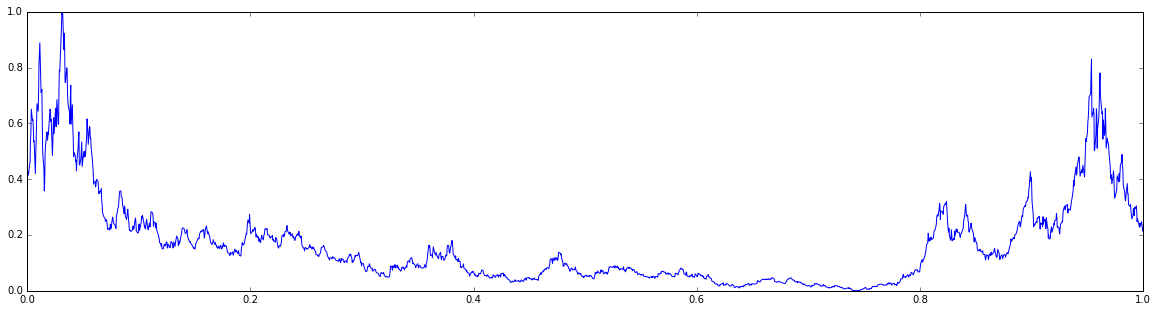

In [22]:
figure(figsize=(20, 5))
plot(X, Y)

In [140]:
NN = NeuralNetwork([1, 8, 8, 1], Lambda=0.00001)
T = Trainer(NN)
T.train(X, Y)

         Current function value: 2.069809
         Iterations: 2055
         Function evaluations: 2290
         Gradient evaluations: 2278


In [152]:
T.train(X, Y)

         Current function value: 1.987698
         Iterations: 24
         Function evaluations: 75
         Gradient evaluations: 64


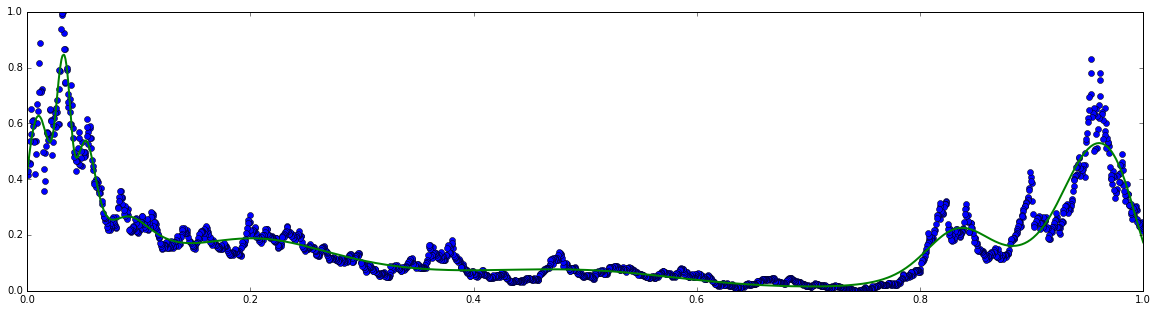

In [161]:
figure(figsize=(20, 5))
plot(X, Y, "o")
plot(X, NN.forward(X), linewidth=2)

In [188]:
sample = sampleNetwork(NN, 10/len(X))

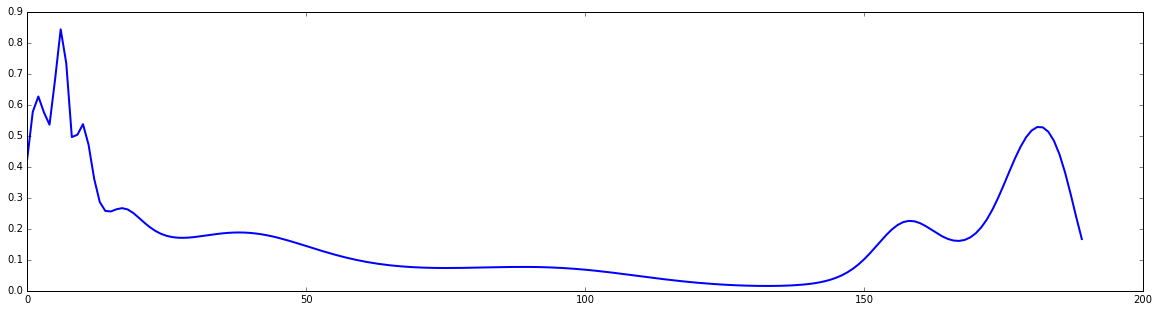

In [194]:
figure(figsize=(20, 5))
plot(sample, linewidth=2)

In [190]:
R = lagAutocorrelation(sample, 100)

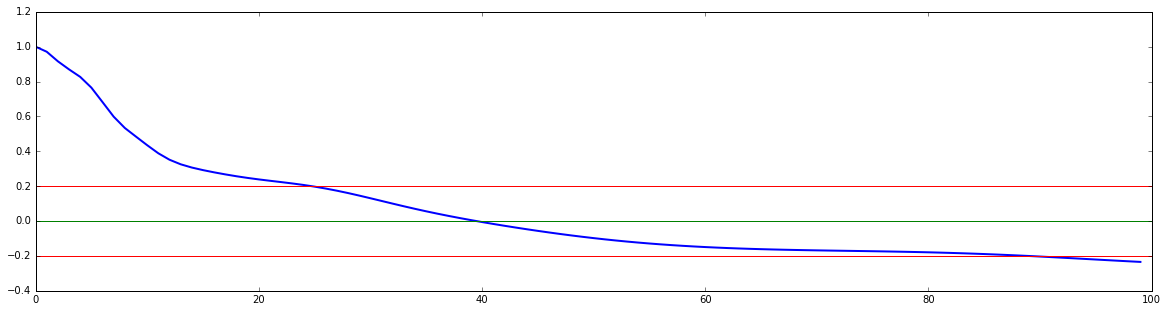

In [195]:
figure(figsize=(20, 5))
plot(R, linewidth=2)
plot([0, 100], [0.2, 0.2], color="red")
plot([0, 100], [-.2, -.2], color="red")
plot([0, 100], [0,0], color="green")

In [192]:
NNx = NeuralNetwork([10, 8, 7, 1], Lambda = 0.00001)
Tx = Trainer(NNx)

In [196]:
sample_1 = sample[:100]
sample_2 = sample[100:]

In [201]:
l_sample_1x, l_sample_1y = lagSample(sample_1, 10, 1, 1)
l_sample_2x, l_sample_2y = lagSample(sample_2, 10, 1, 1)

In [202]:
Tx.train(l_sample_1x, l_sample_1y)

         Current function value: 0.001021
         Iterations: 260
         Function evaluations: 343
         Gradient evaluations: 331


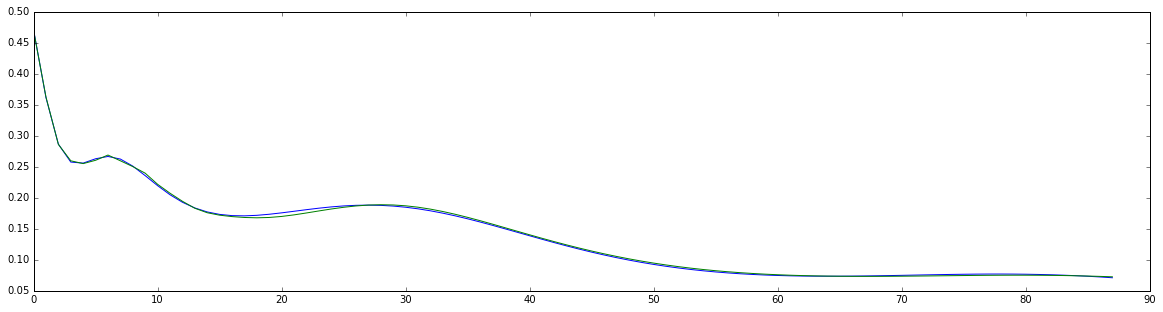

In [209]:
figure(figsize=(20, 5))
plot(l_sample_1y)
plot(NNx.forward(l_sample_1x))

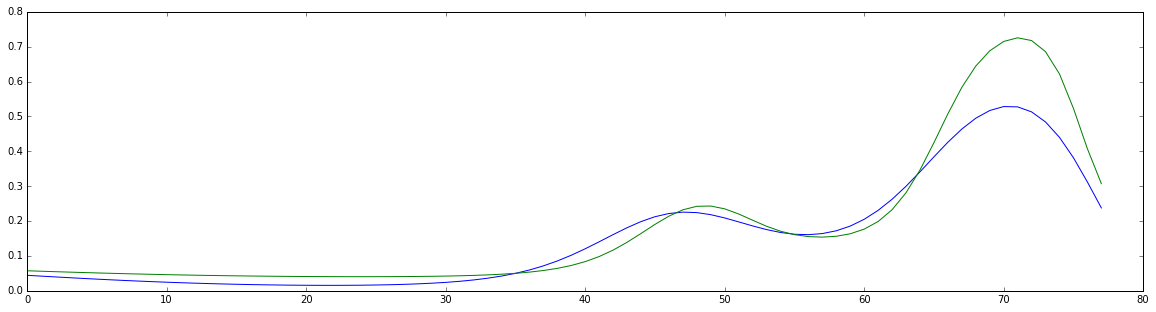

In [210]:
figure(figsize=(20, 5))
plot(l_sample_2y)
plot(NNx.forward(l_sample_2x))

In [442]:
class GeneticTrainer(object):
    
    def __init__(self, NN, popSize):
        self.NN = NN
        self.popSize = popSize
        
        #hardcoded consants for now
        self.genomeMutationChance = 0.5
        self.geneMutationChance = 0.2
        self.perturbSize = 0.4
        self.tournamentSize = int(self.popSize / 5)
        
        
    #return the most fit individual
    def getMostFit(self, population, fitnesses):
        strongest = population[0]
        strongest_index = 0
        for i in range(1, len(population)):
            if (fitnesses[i] > fitnesses[strongest_index]):
                strongest = population[i]
                strongest_index = i
        return strongest
    
    #mutate an individual based on chance
    def mutate(self, genome):
        if(np.random.random(1)[0] < self.genomeMutationChance):
            for i in range(0, self.genomeLength):
                if(np.random.random(1)[0] < self.geneMutationChance):
                    genome[i] += self.perturbSize * np.random.randn(1)[0]
        return genome
    
    def tournament(self, population, fitnesses, tournamentSize):
        tournament = np.empty(tournamentSize, dtype=object)
        tournamentFitnesses = np.empty(tournamentSize)
        selection = np.arange(0, self.popSize)
        for i in range(0, tournamentSize):
            index = np.random.randint(0, len(selection))
            index = selection[index]
            tournament[i] = population[index]
            tournamentFitnesses[i] = fitnesses[index]
            np.delete(selection, index)
        return self.getMostFit(tournament, tournamentFitnesses)
    
    def crossover(self, genome1, genome2):
        if(np.random.random(1)[0] < 0.2):
            pivot = np.random.randint(0, len(genome1))
            genome = genome1[:pivot]
            genome = np.concatenate((genome, genome2[pivot:]))
            return genome
        else:
            genome = genome1 + genome2
            genome /= 2
            return genome
    
    def train(self, X, Y, generations, **initial_pop):
        #generate a random initial population
        self.genomeLength = len(self.NN.getParams())
        self.population = np.empty(self.popSize, dtype=object)
        
        if("initial" in initial_pop):
            for i in range(0, self.popSize):
                self.population[i] = initial_pop["initial"]
        else:
            for i in range(0, self.popSize):
                individual = np.random.randn(self.genomeLength)
                self.population[i]=individual
        
        #do evolution for a specified number of generations
        for i in range(0, generations):
            #evaluate the fitness of each individual
            self.fitnesses = np.empty(self.popSize)
            for p in range(0, self.popSize):
                genome = self.population[p]
                self.NN.setParams(genome)
                fitness = 1000/self.NN.costFunction(X, Y) #invese relation under 1000 for some decimal precision
                self.fitnesses[p]=fitness
            
            #breed the next generation
            #keep one elite child
            nextPopulation = np.empty(self.popSize, dtype=object)
            nextPopulation[0] = self.getMostFit(self.population, self.fitnesses)
            #breed to fill up the next generation
            for p in range(1, self.popSize):
                genome1 = self.tournament(self.population, self.fitnesses, self.tournamentSize)
                genome2 = self.tournament(self.population, self.fitnesses, self.tournamentSize)
                nextPopulation[p] = self.crossover(genome1, genome2)
            #mutate the population
            for p in range(1, self.popSize):
                self.mutate(nextPopulation[p])
                
            # set the new population
            self.population = nextPopulation
        
        self.NN.setParams(self.population[0])

In [443]:
NNg = NeuralNetwork([1, 6, 6, 1], Lambda = 0.0001)
GT = GeneticTrainer(NNg, 50)

In [438]:
GT.train(X, Y, 100)

In [444]:
GT.train(X, Y, 1000, initial = NNg.getParams())

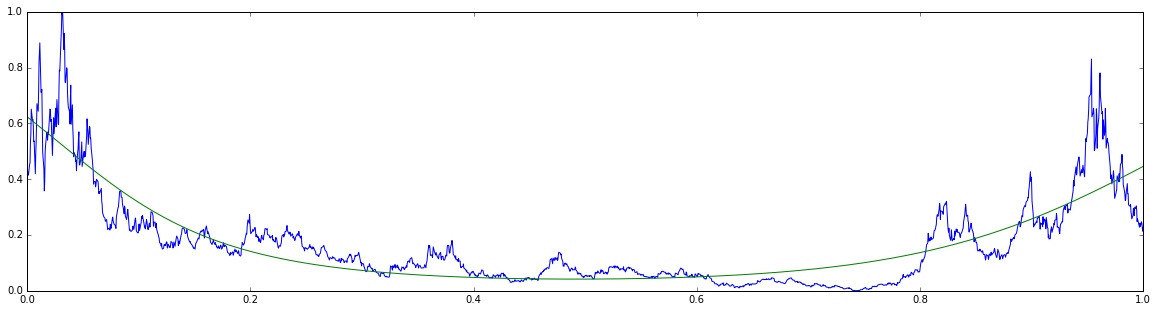

In [445]:
figure(figsize=(20, 5))
plot(X, Y)
plot(X, NNg.forward(X))